Librerias pertinentes:

In [1]:
# import librarys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient 
import os
from dotenv import load_dotenv
from pymongo import MongoClient
import configparser
from pprint import pprint as pp
import json

# librarys ML
from sklearn.neural_network import MLPRegressor
import cv2

Conexion a la basa de datos, para extraer los Bson de MongoDB:

In [2]:
# Connection and variables to request
#=========== connection to mongoDB ===============#
# Reading credentials from environment
load_dotenv() # esto es para que pueda cargar las variables de entorno
MONGO_USERNAME = os.environ.get("MONGO_USERNAME")
MONGO_PASSWORD = os.environ.get("MONGO_PASSWORD")
DB_Server = os.environ.get("DB_SERVER_IP")

# Loading the configuration
config = configparser.ConfigParser()
config.read('config/satConfig.ini')
annDB = config['DBs']['annotation']

# functions to make connections to MongoDB
def open_DB():
    client = MongoClient(host=DB_Server, port=27017, 
                            username=MONGO_USERNAME, password=MONGO_PASSWORD)
    return(client)

# Opening both database collections and creating the links to the key tables
mongoClient = open_DB()
dbInternal = mongoClient[annDB]
# ==== Key Tables ====
site_annotations = dbInternal['SiteAnnotations']
## ================================================================= ##

In [ ]:
def getArea(Points, PixelSize): # calcula el area de un poligono
    ''' Calculaing the physical area of a Countour'''
    C_array = np.array(Points, dtype=int)
    return(int(cv2.contourArea(C_array)*(PixelSize**2)))


def getPerimeter(Points, PixelSize): # calcula el perimetro, el cual es la suma de sus lados
    ''' Calculating the physical perimeter of a Countour'''
    C_array = np.array(Points, dtype=int)
    return(int(cv2.arcLength(C_array, True)*PixelSize))


In [103]:
df_info = pd.read_json(r"config\images_info.json")
annotations = []

for Id, x2, y2 in zip(df_info["id"], df_info["x"], df_info["y"]): 
    
    annotation = site_annotations.find_one({"id":Id})
    x1,y1 = annotation["ImageSize"]
    resolution = annotation["Resolution"]/12
    new_annotation = []
    
    for annot in annotation["Annotations"]:
        
        points = annot["Points"]
        # new_points = [[(point[0]*2494)/2048,(point[1]*2432)/2048] for point in points]
        new_points = [[(point[0]*x2)/x1,(point[1]*y2)/y1] for point in points]
        
        area = getArea(new_points, resolution)
        perimeter = getPerimeter(new_points, resolution)
        
        annot["Attributes"]["area"] = area
        annot["Attributes"]["perimeter"] = perimeter
        annot["Points"] = new_points
        
        new_annotation.append(annot)
    
    annotation["Annotations"] = new_annotation
    annotation["ImageSize"] = [x2,y2]
    annotations.append(annotation)


In [107]:
"""Estimacion del HP del RTU por su area cuadrada"""
data = []
for annotation in annotations:
    id = annotation["id"]
    for annot in annotation["Annotations"]:
        if annot["Class"] != "Building" and annot["Attributes"]["HP"] != "0.00":
            data.append({
                "id":id,
                "area": annot["Attributes"]["area"],
                "hp":  float(annot["Attributes"]["HP"])
            })

df = pd.DataFrame(data)

1496


Acomodamos las areas y los perimetros de las anotaciones 

In [108]:
area = df["area"]
hp = df["hp"]
print(np.corrcoef(area, hp)[0,1]) # margen de correlacion

0.7650733296586757


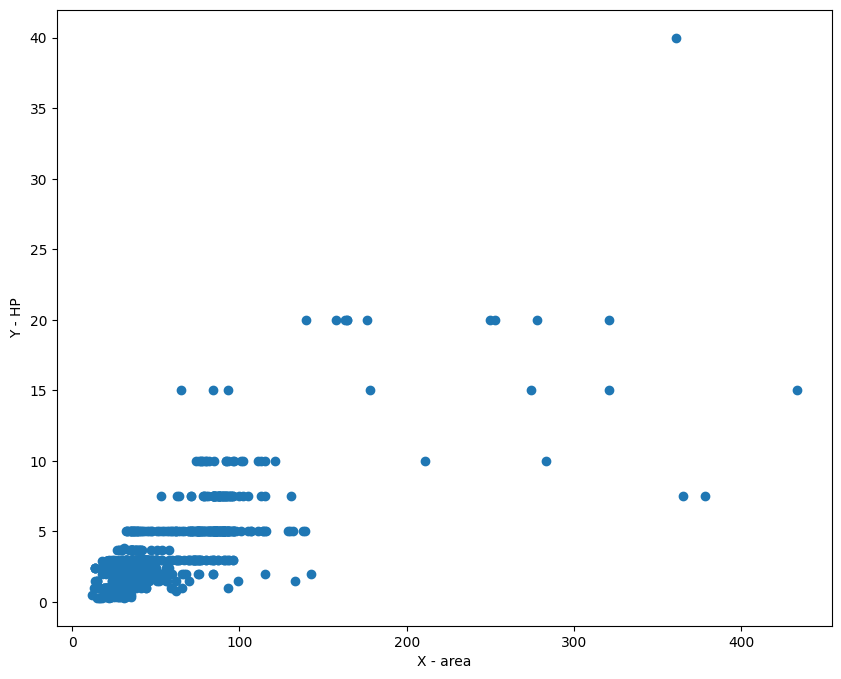

In [109]:
x = area
y = hp
plt.scatter(x, y)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.xlabel('X - area')
plt.ylabel('Y - HP')
plt.show()

In [4]:
"""
    Intentetamos predecir el HP de un edificio con su area con el pie cuadrado
    dependiendo del area va a ser su hp y este lo dividimos entre el N° de RTU
    y ese va ser la mededia para cada uno.
"""

data = []
data2 = []

for anno in annos:
    
    area_building =  [area["Attributes"]["area"] for area in anno["Annotations"] if area["Class"] == "Building"][0]
    # perimeter_building = [perimeter["Attributes"]["perimeter"] for perimeter in anno["Annotations"] if perimeter["Class"] == "Building"]
    #RTU_area  = [area["Attributes"]["area"] for area in anno["Annotations"][1:] if area["Class"] != "Building"]
    # RTU_perimeter = [perimeter["Attributes"]["perimeter"] for perimeter in anno["Annotations"] if perimeter["Class"] != "Building"]
    RTU_HP = [float(hp["Attributes"]["HP"]) for hp in anno["Annotations"] if hp["Class"] != "Building"]
    sum_HP = round(sum(RTU_HP),2)
    if sum_HP == 0: continue
        
    data.append(
        {
            "id":anno["id"],
            "area_building": area_building,
            #"perimeter_building": perimeter_building[0],
            "RTU_count": anno["Annotations"][0]["Attributes"]["RTU_count"],
            # "RTU_area": RTU_area,
            #"RTU_perimeter": RTU_perimeter,
            "RTU_HP": RTU_HP,
            "sum_HP": sum_HP
        }
    )

for dt in data:
    if 0.0 not in dt["RTU_HP"]:
        data2.append({
            # "id":dt["id"],
            "area_building": dt["area_building"],
            #"perimeter_building": dt["perimeter_building"],
            # "RTU_count": dt["RTU_count"],
            # "RTU_area": dt["RTU_area"],
            # "RTU_perimeter": dt["RTU_perimeter"],
            # "RTU_HP": dt["RTU_HP"],
            "sum_HP": dt["sum_HP"]
        })

df = pd.DataFrame(data)
df.to_csv(r"excel\data.csv", index=False)

df2 = pd.DataFrame(data2)
df.to_csv(r"excel\data2.csv", index=False)

In [21]:
area = np.array([2668, 19369, 7893, 8050, 12049, 6479, 13546, 1005, 15771, 14098, 1800, 14151, 19290, 12484, 16013, 8819, 14604, 12871, 12321, 1241, 13955, 21199, 17366, 18076, 12849, 14629, 9267, 14583, 24780, 4697, 2958, 8431, 22431, 17022, 13796, 7411, 2273, 7986, 22519, 15850, 19649, 15098, 6645, 2368, 8462, 8761, 21424, 18695, 11115, 11948, 7276, 11219, 24257, 19062, 20345, 13768, 23695, 18585, 24604, 11431, 23552, 15940, 17941, 6959, 21664, 21022, 7780, 7082, 16464, 4637, 23276, 5703, 2165, 12924, 19961, 3550, 1609, 14297, 7161, 16125, 5655, 2961, 18016, 11107, 4287, 4038, 6297, 8773, 2662, 12037, 4151, 6997, 20785, 11918, 17863, 16852, 12138, 17995, 7306, 12904, 13062, 13523, 19307, 24999, 3023, 16290, 10050, 18467, 14041, 6826, 23073, 15347, 13308, 9933, 10017, 17443, 10973, 13198, 8316, 12776, 20687, 21498, 18467, 20926, 10684, 16976, 13795, 23158, 24257, 21612, 10652, 6998, 6544, 12581, 15538, 16273, 8372, 6741, 10642, 19521, 9079, 13790, 2328, 11397, 22906, 5054, 16318, 23443, 9871, 15912, 12324, 15509, 18077, 16567, 18515, 19451, 1230, 22635, 9942, 14417, 21164, 18666, 5012, 14523, 1514, 23980, 15924, 6165, 7088, 17706, 23917, 14534, 9999, 20524, 23050, 1547, 21641, 5481, 4956, 19644, 17686, 7666, 24228, 22572, 19603, 5187, 10350, 15846, 20494, 24933, 24214, 17749, 4743, 23147, 2807, 16725, 18717, 9386, 12543, 24263, 12772, 17091, 5200, 14358, 12995, 18666, 14597, 23240, 6918, 19464, 15603, 1229, 10049, 24768, 1721, 13482, 11130, 18701, 7893, 10464, 9237, 1621, 24376, 10762, 16384, 18598, 11228, 22922, 21563, 12575, 18062, 13929, 6591, 10538, 17207, 12087, 22965, 23077, 12111, 4299, 10773, 4070, 19086, 19252, 22677, 20906, 23772, 19805, 3097, 8302, 5910, 22443, 23201, 24306, 16159, 11371, 13704, 11865, 24055, 1395, 22065, 14313, 16610, 3326, 18536, 10568, 10221, 6688, 14246, 2336, 5652, 17859, 15763, 12322, 6442, 17436, 10449, 7756, 10295, 1161, 13410, 20761, 20044, 23752, 5372, 9536, 7276, 1161, 5473, 4068, 4297, 16823, 20839, 21573, 8447, 8816, 22529, 9362, 1449, 6399, 2437, 7259, 20552, 13767, 20607, 4826, 10093, 18768, 22651, 6927, 3855, 18084, 13788, 2917, 18140, 3921, 17181, 21405, 1548, 1741, 13175, 17527, 4990, 13668, 12746, 17632, 19043, 12338, 15104, 22448, 17126, 23209, 9587, 3390, 8619, 4014, 17147, 13844, 16470, 4764, 22231, 11395, 7001, 21179, 24498, 13451, 6378, 4568, 3646, 21425, 1456, 15704, 3772, 16860, 9053, 15757, 14901, 10482, 22946, 5275, 7169, 2914, 21273, 2433, 16091, 21505, 14083, 9548, 22630, 21721, 7632, 22823, 24870, 5554, 5624, 17239, 10713, 17508, 9959, 23209, 18136, 21772, 2168, 10250, 3408, 20794, 23394, 11785, 23473, 23017, 1808, 9988, 2729, 4495, 2091, 15712, 21422, 7139, 2484, 21708, 24463, 7596, 22765, 20992, 14067, 24346, 12168, 23118, 9136, 18274, 12903, 2059, 4830, 19729, 13181, 22839, 24860, 21025, 13885, 6030, 21426, 6999, 22726, 16637, 4212, 3123, 17236, 2425, 2659, 7798, 15473, 18617, 11554, 3357, 7927, 10957, 6677, 20699, 16754, 13008, 9727, 12693, 18427, 13275, 10877, 12055, 21049, 10196, 16471, 4000, 4588, 15438, 12777, 24854, 1575, 16094, 18930, 22980, 22165, 8386, 23887, 3577, 1741, 11662, 17049, 6484, 11354, 13834, 4989, 5447, 14823, 3930, 23351, 5440, 3284, 19757, 22547, 6316, 2642, 17470, 20036, 8315, 2168, 15556, 20041, 13216, 23335, 24138, 11666, 10664, 22349, 23663, 15315, 8789, 19643, 10707, 10945, 7569, 15860, 10980, 18739, 13140, 14505, 14167, 14617, 18170, 23377, 18559, 11343, 6758, 11880, 23256, 8918, 20994, 20299, 15198, 7419, 23235, 21336, 10526, 14162, 18758, 21293, 17582, 6102, 5446, 12320, 7301, 18977, 10375, 24847, 15589, 1604, 19556, 14231, 23868, 14908, 17245, 2446, 10042, 18235, 15545, 14469, 18770, 5102, 5380, 6400, 22610, 15339, 21321, 10828, 21952, 19220, 9279, 6722, 20924, 1085, 10697, 21608, 21722, 3003, 10355, 7808, 6005, 6814, 21585, 8673, 24995, 17306, 12020, 18778, 12652, 8901, 11589, 14509, 16164, 3340, 9902, 4194, 12083, 22174, 8859, 22374, 11827, 19591, 22386, 6449, 23217, 6851, 5749, 5660, 18816, 11638, 23143, 12221, 11649, 8151, 16265, 20247, 24886, 23503, 22563, 10211, 8175, 19813, 14419, 2439, 2089, 24564, 11452, 17258, 13931, 17798, 15113, 20932, 16191, 10444, 2327, 20778, 2024, 3669, 1045, 1714, 10841, 22033, 14515, 17893, 19728, 2177, 4055, 3238, 12168, 15932, 4896, 23558, 12909, 3110, 6081, 24118, 13051, 1335, 13590, 17557, 7261, 18697, 7746, 7757, 16281, 23751, 14657, 18031, 20364, 18215, 5985, 21234, 21972, 18051, 6738, 19664, 13202, 22718, 12904, 4761, 9855, 11994, 5345, 7846, 4725, 19672, 23175, 12896, 19061, 12832, 22954, 8462, 15413, 20710, 8403, 6673, 15727, 10551, 14966, 12653, 21228, 23698, 21521, 1981, 2515, 15871, 20918, 13018, 2116, 12628, 3475, 18425, 13568, 22105, 22159, 4373, 19946, 13821, 16098, 24852, 23772, 4074, 5367, 18644, 1863, 5581, 11928, 16023, 7473, 6199, 6398, 15563, 23857, 14229, 2520, 8076, 16952, 3707, 14217, 9989, 23383, 22984, 18963, 23176, 14048, 16167, 19105, 14199, 20965, 4651, 13057, 1195, 13698, 23410, 22091, 14516, 5491, 9538, 1508, 12062, 17485, 10381, 14620, 12888, 24389, 13085, 11383, 23416, 17042, 19904, 13460, 19616, 16513, 3898, 12409, 23163, 18209, 6280, 17597, 14342, 19241, 10374, 14764, 4949, 19582, 5628, 15265, 5838, 8934, 16407, 9031, 9173, 10588, 18195, 7887, 8856, 14287, 23555, 22355, 18386, 11476, 23944, 14284, 10015, 23893, 15769, 14168, 23503, 13303, 9446, 17747, 17825, 2960, 4258, 8283, 3234, 3072, 1873, 1465, 5396, 19778, 10755, 15542, 24873, 19956, 2500, 10247, 2227, 16261, 23161, 3357, 13627, 2270, 13709, 15727, 6713, 22716, 21308, 4179, 20183, 6552, 9662, 24229, 2504, 13527, 11367, 5712, 1493, 19076, 11924, 24013, 22773, 21948, 14961, 6618, 13381, 1880, 16394, 19054, 19436, 20457, 1182, 24936, 1870, 22514, 11547, 24129, 23494, 7049, 18193, 16780, 15997, 12746, 4688, 2160, 19945, 14284, 3059, 20712, 21779, 9994, 2031, 2160, 13498, 24686, 24689, 1400, 23367, 12224, 3067, 15468, 16437, 24911, 1368, 11816, 22813, 4200, 11187, 18524, 18757, 18600, 15477, 10428, 19328, 6463, 16081, 14078, 10248, 17152, 1960, 4185, 22965, 15085, 19777, 18109, 18877, 11360, 20712, 9593, 5621, 22337, 13262, 8713, 14252, 21850, 4612, 12410, 23562, 9698, 17238, 24660, 21396, 18196, 9696, 17378, 6689, 8106, 12769, 23203, 20501, 16282, 16755, 17727, 10101, 2093, 15764, 23534, 3302, 3409, 8476, 10456, 8100, 21032, 3882, 15821, 3261, 4176, 10698, 11808, 13346, 18067, 22732, 9214, 4441, 10363, 18952, 18332, 5410, 20966, 18856, 19565, 22610, 9190, 11596, 5242, 17828, 6533, 6119, 1735, 13055, 4243, 11516, 9504, 12995, 17889, 9781, 9192, 21789, 11212, 3145, 11768, 11253, 10501, 13351, 24190, 1695, 14191, 10112, 21221, 17726, 5124, 5477, 8838, 11631, 8403, 3384, 11736, 3224, 20185, 16092, 12197, 20184, 23879, 22440, 24951, 14904, 9997], dtype=int)
hp = np.array([4.0, 21.2, 11.1, 11.8, 17.7, 12.3, 19.9, 2.1, 24.1, 19.4, 4.6, 17.5, 24.6, 16.7, 21.3, 12.2, 17.0, 18.3, 18.2, 2.7, 19.7, 26.8, 24.9, 21.4, 19.7, 19.6, 11.9, 19.4, 27.9, 6.8, 4.9, 13.9, 28.8, 24.9, 18.2, 13.8, 4.9, 12.9, 29.4, 24.4, 21.4, 22.0, 14.2, 4.6, 13.9, 11.2, 28.4, 23.6, 17.7, 17.5, 12.9, 19.6, 28.5, 22.8, 29.0, 17.0, 26.4, 22.9, 28.7, 16.4, 27.7, 24.1, 21.5, 13.8, 28.6, 29.8, 14.5, 13.1, 23.2, 9.5, 27.0, 11.0, 4.5, 16.8, 21.2, 8.0, 4.6, 18.9, 11.2, 25.0, 11.9, 4.2, 24.2, 18.9, 8.0, 9.9, 13.6, 14.9, 4.5, 19.2, 10.0, 14.6, 28.5, 16.5, 22.3, 24.9, 18.4, 23.0, 11.8, 17.9, 17.4, 16.7, 24.1, 27.9, 7.3, 23.1, 17.5, 24.9, 18.5, 14.2, 28.5, 22.1, 16.9, 13.0, 17.4, 22.7, 18.3, 17.7, 11.4, 16.8, 27.1, 29.5, 21.7, 27.3, 17.2, 21.5, 19.4, 27.0, 27.5, 28.0, 19.7, 12.8, 11.3, 18.7, 22.6, 23.0, 13.4, 14.1, 17.7, 24.9, 11.7, 18.5, 5.0, 17.5, 26.4, 11.2, 24.8, 27.0, 11.2, 24.1, 19.5, 23.4, 24.4, 24.8, 21.3, 24.5, 2.6, 28.1, 14.6, 19.6, 28.3, 24.1, 12.5, 16.9, 4.9, 27.2, 24.5, 11.5, 13.9, 22.3, 29.9, 19.2, 14.4, 29.4, 29.4, 5.0, 29.1, 11.3, 8.1, 24.4, 24.9, 13.3, 29.7, 29.5, 22.6, 11.6, 16.1, 22.8, 28.5, 28.2, 29.3, 23.2, 9.0, 27.1, 4.1, 24.2, 24.7, 13.3, 18.7, 28.9, 19.1, 23.3, 13.8, 19.7, 19.9, 21.2, 18.4, 28.5, 11.9, 22.4, 24.4, 2.8, 19.1, 29.4, 4.2, 19.8, 16.2, 21.3, 14.5, 16.5, 11.9, 4.6, 26.3, 19.9, 22.8, 21.1, 18.1, 29.8, 28.7, 16.5, 23.3, 19.8, 14.0, 19.7, 22.4, 18.8, 28.9, 26.5, 18.2, 6.9, 18.6, 6.3, 22.3, 23.2, 28.1, 27.4, 28.0, 24.7, 6.3, 15.0, 12.7, 29.4, 28.8, 29.2, 22.0, 17.2, 16.2, 19.1, 27.5, 2.5, 26.4, 18.8, 21.4, 8.1, 21.9, 16.6, 17.6, 11.1, 19.5, 4.9, 12.6, 24.5, 22.7, 16.7, 14.4, 24.8, 19.2, 13.1, 17.2, 2.4, 16.4, 26.0, 27.4, 26.1, 14.6, 11.2, 11.0, 2.1, 11.4, 9.0, 8.7, 23.2, 29.9, 29.3, 12.6, 12.3, 29.0, 14.1, 2.8, 12.7, 4.4, 11.6, 29.0, 19.8, 29.2, 9.9, 19.7, 24.4, 26.4, 13.2, 9.3, 23.8, 16.5, 4.7, 21.7, 7.1, 21.1, 27.7, 4.2, 4.3, 18.6, 24.5, 7.3, 19.5, 16.1, 21.8, 24.5, 16.3, 21.5, 29.1, 24.9, 27.6, 13.8, 9.0, 13.7, 6.9, 21.1, 17.6, 21.6, 9.3, 27.3, 17.5, 13.4, 26.8, 27.2, 18.8, 13.7, 7.8, 7.4, 27.1, 2.1, 23.5, 7.8, 21.1, 12.6, 24.8, 18.4, 17.8, 29.9, 13.8, 13.9, 4.8, 28.1, 4.6, 22.4, 26.9, 18.2, 13.0, 28.2, 27.2, 14.8, 27.5, 29.6, 13.3, 11.9, 23.8, 19.0, 22.3, 11.5, 28.7, 24.7, 29.4, 4.3, 17.4, 8.5, 26.6, 27.3, 19.5, 29.4, 26.6, 4.1, 14.6, 4.9, 6.1, 5.0, 24.5, 26.7, 13.6, 4.9, 26.8, 28.8, 12.1, 27.2, 27.9, 18.6, 27.3, 17.3, 27.8, 12.7, 24.8, 17.1, 4.5, 6.0, 21.3, 16.8, 26.0, 27.5, 29.8, 19.1, 12.8, 28.3, 11.7, 28.4, 24.1, 8.5, 8.4, 21.6, 4.3, 4.2, 14.8, 23.5, 22.7, 16.6, 8.7, 12.5, 19.7, 14.8, 27.4, 22.9, 18.4, 12.4, 17.2, 23.8, 17.7, 16.4, 18.4, 27.1, 17.3, 24.6, 6.2, 6.4, 24.5, 19.3, 28.0, 4.3, 25.0, 21.2, 26.1, 26.4, 12.3, 30.0, 6.4, 4.5, 19.5, 23.1, 12.1, 17.1, 16.7, 6.9, 13.3, 18.1, 7.3, 27.8, 14.5, 9.8, 21.7, 28.8, 13.7, 4.6, 21.6, 29.7, 14.4, 4.4, 23.3, 26.8, 18.3, 28.2, 27.8, 17.3, 19.7, 27.6, 27.2, 21.4, 12.6, 22.6, 16.6, 19.3, 14.8, 21.9, 17.7, 21.9, 17.6, 18.1, 17.5, 16.6, 22.8, 28.9, 21.3, 19.0, 12.8, 16.8, 29.0, 11.1, 27.0, 28.7, 21.0, 11.2, 29.2, 28.6, 19.6, 19.7, 24.7, 29.7, 21.5, 11.6, 14.8, 18.9, 12.9, 23.8, 19.7, 26.5, 24.0, 4.1, 22.6, 19.7, 28.6, 18.4, 22.3, 4.7, 18.3, 22.0, 22.1, 18.6, 23.9, 11.9, 12.5, 14.3, 29.2, 23.1, 27.0, 17.7, 27.0, 24.8, 12.9, 14.0, 26.9, 2.1, 16.9, 28.9, 28.2, 9.6, 18.5, 12.9, 12.8, 12.3, 28.3, 12.6, 27.9, 21.6, 18.5, 22.0, 18.5, 11.3, 17.1, 18.6, 23.6, 9.5, 14.4, 6.7, 20.0, 27.3, 14.7, 29.7, 16.7, 24.7, 26.8, 14.4, 29.4, 15.0, 12.8, 13.4, 23.0, 19.2, 29.9, 18.8, 19.4, 12.5, 21.0, 27.3, 28.8, 28.8, 28.2, 17.5, 11.4, 24.9, 19.0, 4.4, 4.4, 29.3, 17.8, 24.3, 17.6, 22.6, 22.4, 29.1, 23.3, 19.7, 4.4, 27.2, 4.7, 8.7, 2.0, 4.1, 16.2, 28.8, 16.6, 24.7, 21.2, 4.1, 9.8, 9.6, 16.9, 22.3, 8.4, 26.6, 16.9, 7.8, 14.3, 28.2, 19.0, 2.4, 18.5, 23.5, 14.2, 22.1, 13.6, 12.8, 24.7, 28.3, 16.4, 23.2, 29.8, 23.2, 11.1, 27.4, 27.6, 23.1, 13.7, 23.2, 16.8, 28.5, 19.4, 7.0, 13.2, 16.9, 14.1, 13.5, 6.2, 23.3, 29.4, 19.8, 21.5, 17.1, 29.9, 11.4, 23.7, 28.7, 14.3, 14.0, 22.3, 17.8, 17.5, 18.3, 26.4, 27.8, 28.7, 4.4, 4.7, 24.0, 28.6, 17.5, 4.9, 19.3, 7.3, 24.9, 17.6, 29.8, 26.8, 6.8, 22.8, 19.9, 23.8, 27.8, 29.7, 7.4, 13.2, 23.6, 4.3, 15.0, 19.5, 22.5, 11.4, 11.6, 14.0, 22.0, 27.1, 16.3, 4.4, 14.3, 23.1, 6.2, 19.5, 13.3, 28.0, 29.4, 24.9, 26.7, 19.0, 21.1, 21.9, 16.8, 28.6, 6.5, 19.3, 2.4, 17.6, 28.0, 28.8, 18.0, 12.9, 13.7, 4.0, 19.0, 21.3, 17.7, 17.4, 17.5, 28.9, 16.9, 19.6, 26.5, 23.3, 22.0, 19.5, 23.1, 21.8, 6.9, 18.5, 29.7, 22.8, 12.8, 21.2, 19.0, 22.9, 19.9, 17.7, 8.6, 23.1, 14.1, 24.3, 14.6, 11.7, 21.5, 11.2, 12.9, 18.5, 22.7, 11.2, 12.3, 16.2, 27.8, 28.7, 22.5, 18.5, 27.3, 20.0, 19.8, 29.4, 24.2, 17.8, 29.1, 18.0, 12.0, 22.5, 22.5, 4.9, 6.4, 12.6, 7.8, 9.8, 4.7, 2.1, 13.8, 24.3, 17.2, 21.1, 27.9, 22.9, 4.8, 17.8, 4.7, 24.2, 26.8, 7.3, 19.1, 4.0, 18.8, 22.0, 12.8, 29.3, 29.8, 8.7, 29.7, 12.8, 11.8, 27.2, 4.6, 16.2, 18.7, 14.1, 2.4, 22.3, 16.8, 29.3, 26.3, 29.5, 18.4, 11.9, 18.4, 4.9, 21.8, 22.3, 21.2, 26.8, 2.3, 26.7, 4.6, 26.6, 16.3, 29.0, 27.7, 14.4, 22.1, 24.6, 22.6, 16.7, 6.3, 4.7, 22.8, 16.8, 8.6, 29.6, 28.7, 13.4, 4.9, 4.6, 16.9, 26.1, 29.5, 2.7, 29.6, 17.7, 9.1, 24.8, 23.2, 28.6, 2.4, 16.4, 28.3, 6.4, 16.3, 24.7, 23.4, 24.4, 22.6, 16.3, 21.6, 11.4, 23.6, 17.9, 19.4, 24.7, 4.7, 8.2, 29.9, 22.1, 24.2, 21.8, 22.1, 17.2, 29.1, 11.2, 11.9, 29.7, 19.5, 12.1, 17.9, 28.2, 8.5, 17.5, 26.9, 13.4, 24.5, 28.7, 26.9, 21.5, 14.9, 24.2, 13.1, 11.2, 18.3, 27.8, 26.6, 23.5, 24.9, 21.8, 16.8, 4.6, 21.5, 26.8, 8.0, 6.7, 11.3, 16.2, 13.2, 28.8, 9.3, 22.4, 6.4, 8.3, 16.7, 19.8, 17.1, 21.4, 29.8, 11.8, 9.1, 16.8, 23.5, 24.6, 11.1, 28.2, 21.9, 23.7, 29.9, 12.8, 17.4, 11.7, 23.7, 13.1, 13.1, 4.3, 19.1, 8.3, 18.1, 13.0, 19.2, 23.7, 13.8, 11.4, 29.8, 17.1, 6.1, 17.3, 18.0, 19.2, 19.6, 26.9, 4.6, 20.0, 18.5, 26.4, 22.9, 13.3, 14.7, 14.8, 18.9, 14.5, 6.7, 16.9, 8.3, 29.3, 22.6, 18.9, 27.8, 26.3, 27.3, 26.9, 19.0, 13.3], dtype=float)
print(np.corrcoef(area, hp)[0,1]) # margen de correlacion

0.9653262056999287


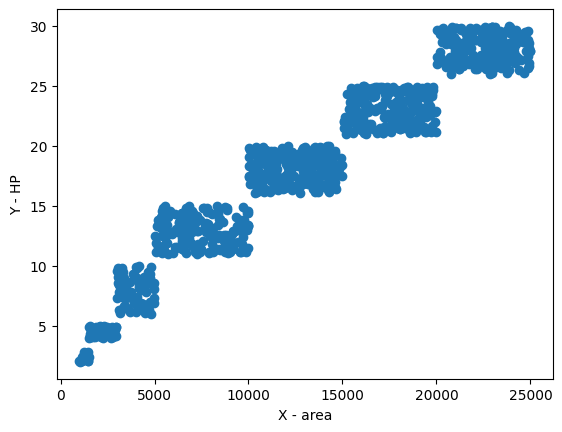

In [7]:
x = area
y = hp
plt.scatter(x, y)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.xlabel('X - area')
plt.ylabel('Y - HP')
plt.show()

In [8]:
X=x[:,np.newaxis]
while True:
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    mlr = MLPRegressor(solver="lbfgs", alpha=1e-5, hidden_layer_sizes=(3,3), random_state=1)
    mlr.fit(X_train, y_train)

    print(mlr.score(X_train, y_train))
    if mlr.score(X_train, y_train) >= 0.93: break

0.9302747289734673


In [9]:
mlr.predict(np.array([[52032]]))

array([59.50315055])